<a href="https://colab.research.google.com/github/santiago2588/Pump_failure_training/blob/main/soluciones/06_light_gbm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data wrangling
import pandas as pd
import numpy as np

In [2]:
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

In [3]:
# Download and run the utils.py file from your GitHub repository
!wget https://raw.githubusercontent.com/santiago2588/pump_failure_training/main/utils.py
%run utils.py

--2025-07-15 14:31:54--  https://raw.githubusercontent.com/santiago2588/pump_failure_training/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2407 (2.4K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   2.35K  --.-KB/s    in 0s      

2025-07-15 14:31:54 (36.2 MB/s) - ‘utils.py.1’ saved [2407/2407]



In [4]:
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline

In [5]:
%pip install optuna -q
import optuna

In [6]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score

In [7]:
!wget https://raw.githubusercontent.com/santiago2588/pump_failure_training/main/data/transformed_data.csv -O transformed_data.csv

# Read the CSV file into a DataFrame
df = pd.read_csv("transformed_data.csv")

# Display the first few rows to confirm it loaded correctly
df.head()

--2025-07-15 14:32:00--  https://raw.githubusercontent.com/santiago2588/pump_failure_training/main/data/transformed_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1210184 (1.2M) [text/plain]
Saving to: ‘transformed_data.csv’

transformed_data.cs 100%[===================>]   1.15M  --.-KB/s    in 0.06s   

2025-07-15 14:32:00 (19.5 MB/s) - ‘transformed_data.csv’ saved [1210184/1210184]



,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium,Failure_type
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0,No Failure
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0,No Failure
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0,No Failure
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0,No Failure
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0,No Failure


In [8]:
# Define features (X) and target variable (y)
X = df.drop('Failure_type', axis=1)  # Features (all columns except 'Failure_type')
y = df['Failure_type']  # Target variable

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the shape of the data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (7978, 8)
Testing data shape: (1995, 8)


In [10]:
# Encode target labels as XGB requires numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [11]:
# Creating pipeline with lgbm classifier and smote
lgbm_smote = Pipeline(steps=[
    ('smote', SMOTE(random_state=2023)),
    ('model', LGBMClassifier(random_state=2023))
])

# Fit pipeline
lgbm_smote.fit(X_train, y_train_encoded)

# Generate Predictions using the correctly fitted pipeline
y_pred = lgbm_smote.predict(X_test)

# Decode predictions back to original labels (optional)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluate Metrics
metrics = get_metrics(y_test_encoded, y_pred)

# View Results
metrics

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 38535, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


{'Accuracy': 0.9729323308270676,
 'Balanced Accuracy': np.float64(0.8068729787998563),
 'Macro Recall': 0.9729323308270676,
 'Macro Precision': 0.9871708567708818,
 'Macro F1': 0.979438394478446,
 'F1 Scores per Class': array([0.89795918, 0.98617992, 0.66666667, 0.79166667, 0.10810811])}

In [12]:
# Creating model with LGBM classifier and balanced class weights

# Compute sample weights for class imbalance
weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Initialize lgbm classifier
lgbm_model = LGBMClassifier(random_state=2023)

# Fit the model with sample weights
lgbm_model.fit(X_train, y_train_encoded, sample_weight=weights)

# Generate predictions
y_pred = lgbm_model.predict(X_test)

# Evaluate metrics
metrics = get_metrics(y_test_encoded, y_pred)

# View results
metrics

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 7978, number of used features: 8
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


{'Accuracy': 0.9849624060150376,
 'Balanced Accuracy': np.float64(0.7608632770391663),
 'Macro Recall': 0.9849624060150376,
 'Macro Precision': 0.9888446148992893,
 'Macro F1': 0.9865775289956211,
 'F1 Scores per Class': array([0.91666667, 0.99249288, 0.66666667, 0.85714286, 0.125     ])}

In [13]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # Number of boosting rounds
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # Maximum tree depth
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # Learning rate
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # Number of leaves in one tree
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),  # Minimum data in leaf
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Subsample ratio of the training data
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Feature subsampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # L2 regularization
    }

    # Initialize the LGBMClassifier with the trial's parameters
    model = LGBMClassifier(random_state=2023, verbosity=-1, **params)

    # Compute sample weights for class imbalance
    weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

    # Fit the model with sample weights
    model.fit(X_train, y_train_encoded, sample_weight=weights)

    # Generate predictions
    y_pred = model.predict(X_test)

    # Evaluate the model using F1-score (or any other metric)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')  # Weighted F1-score for imbalanced data

    return f1  # Optuna will maximize this score

In [14]:
# Create a study object
study = optuna.create_study(direction='maximize')  # We want to maximize F1-score

# Optimize the study
study.optimize(objective, n_trials=20)  # Run 20 trials (you can increase this for better results)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best F1-score:", study.best_value)

[I 2025-07-15 14:32:07,315] A new study created in memory with name: no-name-dad39b2c-cc6c-47c3-aab7-3f92fa9898ac
[I 2025-07-15 14:32:09,669] Trial 0 finished with value: 0.9613090570010793 and parameters: {'n_estimators': 243, 'max_depth': 13, 'learning_rate': 0.04221144586847328, 'num_leaves': 50, 'min_child_samples': 70, 'subsample': 0.7517836308185052, 'colsample_bytree': 0.5635087482849093, 'reg_alpha': 1.585959454220106, 'reg_lambda': 7.2523732725145}. Best is trial 0 with value: 0.9613090570010793.
[I 2025-07-15 14:32:11,495] Trial 1 finished with value: 0.9617458365293472 and parameters: {'n_estimators': 331, 'max_depth': 3, 'learning_rate': 0.06406477145243068, 'num_leaves': 99, 'min_child_samples': 76, 'subsample': 0.9819001881950422, 'colsample_bytree': 0.7571763453589775, 'reg_alpha': 2.0278170375237936, 'reg_lambda': 5.768333169704887}. Best is trial 1 with value: 0.9617458365293472.
[I 2025-07-15 14:32:13,221] Trial 2 finished with value: 0.9393408430756702 and parameters

Best hyperparameters: {'n_estimators': 138, 'max_depth': 8, 'learning_rate': 0.1484000919356986, 'num_leaves': 124, 'min_child_samples': 99, 'subsample': 0.8965023131016437, 'colsample_bytree': 0.8413594400079664, 'reg_alpha': 3.757424759819525, 'reg_lambda': 7.455600924496408}
Best F1-score: 0.9623904557735224


In [15]:
# Extract the best hyperparameters
best_params = study.best_params

# Train the final model with the best hyperparameters
final_model = LGBMClassifier(random_state=2023, verbosity=-1,**best_params)

# Compute sample weights again
weights = compute_sample_weight(class_weight='balanced', y=y_train_encoded)

# Fit the final model
final_model.fit(X_train, y_train_encoded, sample_weight=weights)

# Generate predictions
y_pred = final_model.predict(X_test)

# Evaluate metrics
metrics = get_metrics(y_test_encoded, y_pred)

# Remove 'F1 Scores per Class' from metrics if it exists
if 'F1 Scores per Class' in metrics:
    del metrics['F1 Scores per Class']

# --- Results ---
# The following lines replace the MLflow logging.

# View the best hyperparameters
print("Best Hyperparameters found:")
best_params

# View the final evaluation metrics
print("\nEvaluation Metrics:")
metrics

Best Hyperparameters found:

Evaluation Metrics:


{'Accuracy': 0.9463659147869674,
 'Balanced Accuracy': np.float64(0.9318648939992814),
 'Macro Recall': 0.9463659147869674,
 'Macro Precision': 0.9848352461165851,
 'Macro F1': 0.9623904557735224}

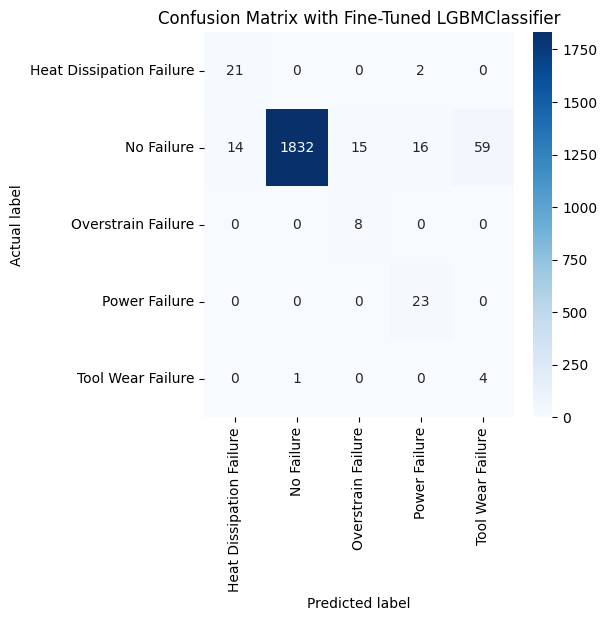

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Decode predictions if necessary
# Assuming y_test contains string labels and y_pred contains numeric labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_decoded)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))  # Larger figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # Use 'd' to format numbers as integers
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))  # Ensure labels match y_test
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix with Fine-Tuned LGBMClassifier')
plt.show()

In [17]:
joblib.dump(final_model, 'final_model.joblib')

['final_model.joblib']